## Traffic Sign Classifier
### Convolutional Neural Networks

### Imports

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import random
import cv2
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
import glob
import matplotlib.image as mpimg


###  Step 0 : Load the Data

In [2]:
training_file, validation_file, testing_file = "../data/train.p", "../data/valid.p", "../data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
print("Dataset Shapes and lenghts \n", "Training Data Shape: \n ", X_train.shape,"\n", "Classes in labels: \n",
      y_train)

Dataset Shapes and lenghts 
 Training Data Shape: 
  (34799, 32, 32, 3) 
 Classes in labels: 
 [41 41 41 ..., 25 25 25]


### Step 1: Dataset Summary & Exploration

In [4]:
df_sign_names = pd.read_csv("signnames.csv")
df_sign_names.head()


,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [5]:
n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(set(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


#### Distribution of the training Dataset

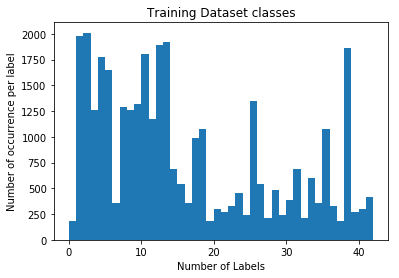

In [6]:
steps = [i for i in range(0,43,1)]
frequency_labels = plt.hist(y_train, bins=steps)
plt.title("Training Dataset classes")
plt.xlabel('Number of Labels')
plt.ylabel('Number of occurrence per label')
plt.show()

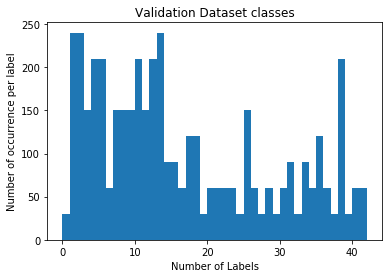

In [7]:
steps = [x for x in range(0,43,1)]
frequency_labels_valid = plt.hist(y_valid, bins=steps)
plt.title("Validation Dataset classes")
plt.xlabel('Number of Labels')
plt.ylabel('Number of occurrence per label')
plt.show()

#### Comparison between Distributions of labels in training and validation dataset

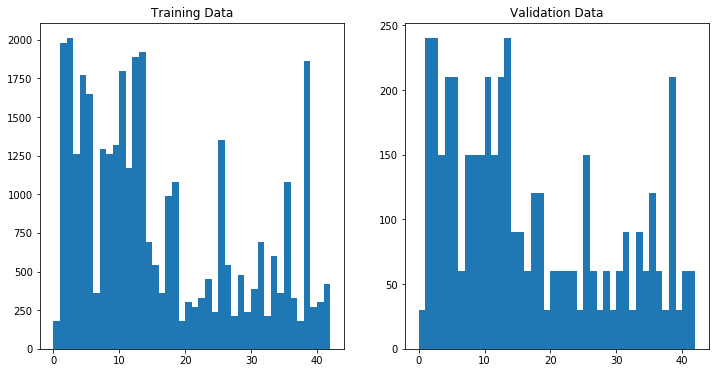

In [8]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].set_title("Training Data")
axs[0].hist(y_train, bins=steps)
plt.title("Validation Data")
axs[1].hist(y_valid, bins=steps)
plt.show()

#### Visual Inspection of the dataset

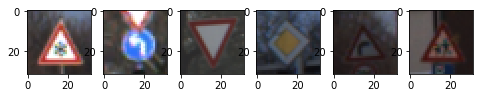

In [9]:
randomizer_int = len(X_train)
fig, axs = plt.subplots(1,6, figsize=(8,8))
for index in range(0,6):
    axs[index].imshow(X_train[random.randrange(randomizer_int)])
plt.show()

### Step 2: Design and Test a Neural Network Architecture

####  Pre-process the Data Set (normalization, grayscale, etc.)

In [10]:
def preprocess(image_data):
    yuv = cv2.cvtColor(image_data, cv2.COLOR_RGB2YUV)
    image_preprocessed = np.divide(yuv, 255)
    return image_preprocessed

#### Preprocessing data

In [11]:
X_train_standarized = np.array([preprocess(image) for image in X_train])
X_valid_standarized = np.array([preprocess(image) for image in X_valid])
X_test_standarized = np.array([preprocess(image) for image in X_test])

#### Model Architecture

In [12]:
EPOCHS = 50
BATCH_SIZE = 128

def LeNet(x):
    mu, sigma = 0, 0.1
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)
    # Dropout
    drop_1 = tf.nn.dropout(conv1, keep_prob)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    pooling_1 = tf.nn.max_pool(drop_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    drop_2 = tf.nn.dropout(pooling_1, keep_prob)

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(drop_2, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Layer 2 : Activation.
    conv2 = tf.nn.relu(conv2)
    
    # Layer 2: Dropout
    drop_3 = tf.nn.dropout(conv2, keep_prob)

    # Layer 2:  Pooling. Input = 10x10x16. Output = 5x5x16.
    pooling_2 = tf.nn.max_pool(drop_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    drop_31 = tf.nn.dropout(pooling_2, keep_prob)
    
    # Convolution Layer 3
    
    conv3_W = tf.Variable(tf.truncated_normal(shape = (5, 5, 16, 16), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(16))
    conv3 = tf.nn.conv2d(drop_31,  conv3_W,  strides=[1, 1, 1, 1], padding='SAME' ) + conv3_b
    
    conv3 = tf.nn.relu(conv3)
    
    drop_4 = tf.nn.dropout(conv3, keep_prob)
    

    #Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(drop_4)
    
    # Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 250), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(250))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    drop_4 = tf.nn.dropout(fc1, keep_prob)

    # Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(250, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(drop_4, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    drop_5 = tf.nn.dropout(fc2, keep_prob)
    
    # Extra fully connected
    
    fce_w = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fce_b  = tf.Variable(tf.zeros(43))
    fce = tf.matmul(drop_5, fce_w) + fce_b
    
    fce = tf.nn.relu(fce)
    drop_6 = tf.nn.dropout(fce, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 10. (change to 43 because of #classes)
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(drop_5, fc3_W) + fc3_b
    
    return logits

#### Initializing variables 

In [13]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)
rate = 0.001

#### Pipeline

In [14]:
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
prediction = tf.argmax(logits, 1)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()


#### Evaluation

In [15]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [16]:

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_standarized, y_train = shuffle(X_train_standarized, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_standarized[offset:end], y_train[offset:end]
            #batch_x, batch_y = x_trn_gr[offset:end], y_trn_gr[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.9})
            
        validation_accuracy = evaluate(X_valid_standarized, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.672

EPOCH 2 ...
Validation Accuracy = 0.820

EPOCH 3 ...
Validation Accuracy = 0.885

EPOCH 4 ...
Validation Accuracy = 0.889

EPOCH 5 ...
Validation Accuracy = 0.909

EPOCH 6 ...
Validation Accuracy = 0.922

EPOCH 7 ...
Validation Accuracy = 0.929

EPOCH 8 ...
Validation Accuracy = 0.934

EPOCH 9 ...
Validation Accuracy = 0.932

EPOCH 10 ...
Validation Accuracy = 0.926

EPOCH 11 ...
Validation Accuracy = 0.939

EPOCH 12 ...
Validation Accuracy = 0.939

EPOCH 13 ...
Validation Accuracy = 0.951

EPOCH 14 ...
Validation Accuracy = 0.945

EPOCH 15 ...
Validation Accuracy = 0.939

EPOCH 16 ...
Validation Accuracy = 0.939

EPOCH 17 ...
Validation Accuracy = 0.943

EPOCH 18 ...
Validation Accuracy = 0.932

EPOCH 19 ...
Validation Accuracy = 0.941

EPOCH 20 ...
Validation Accuracy = 0.932

EPOCH 21 ...
Validation Accuracy = 0.924

EPOCH 22 ...
Validation Accuracy = 0.932

EPOCH 23 ...
Validation Accuracy = 0.949

EPOCH 24 ...
Validation Accura

#### Train, Validate and Test the Model


In [17]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    print("\n  Training set accuracy = {:.3f}".format(evaluate(X_train_standarized, y_train)))
    print("Validation set accuracy = {:.3f}".format(evaluate(X_valid_standarized, y_valid)))
    print("      Test set accuracy = {:.3f}".format(evaluate(X_test_standarized, y_test)))

INFO:tensorflow:Restoring parameters from ./lenet

  Training set accuracy = 0.999
Validation set accuracy = 0.951
      Test set accuracy = 0.946


### Step 3 : Test model on new images

In [25]:
def image_loader():
    set_of_images = []
    test_images = glob.glob('../CarND-Traffic-Sign-Classifier-Project/example_signs/small/test*jpg')
    for image in test_images:
        img = mpimg.imread(image)
        img = cv2.resize(img, (32,32), interpolation = cv2.INTER_AREA)
        set_of_images.append(img)
        number_of_images = len(set_of_images)
    return set_of_images

In [26]:
new_images = image_loader()


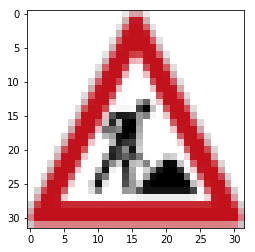

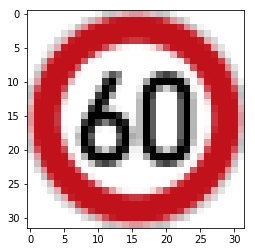

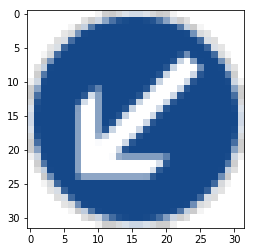

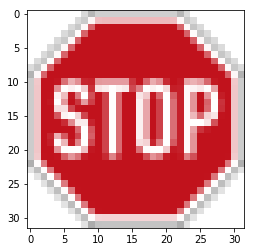

In [27]:
for image in (new_images):
    plt.figure()
    plt.imshow(image)

In [33]:
y_new = [25, 3, 39, 14]


In [28]:
x_new = np.array([preprocess(image) for image in new_images])


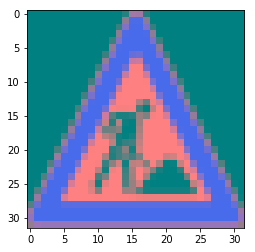

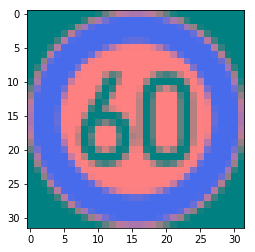

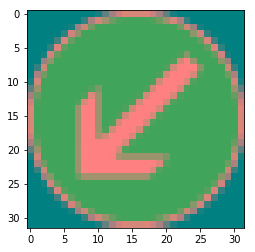

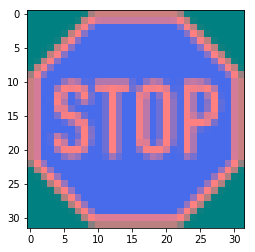

In [29]:
for image in (x_new):
    plt.figure()
    plt.imshow(image)

In [23]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predictions = sess.run(prediction, feed_dict={x: x_new, keep_prob:1.0})
    
print(predictions)

INFO:tensorflow:Restoring parameters from ./lenet
[25  3 39 14]


### Predict the Sign Type for Each Image

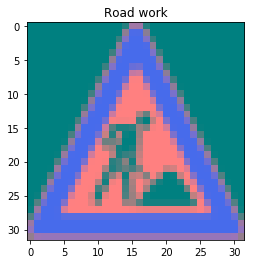

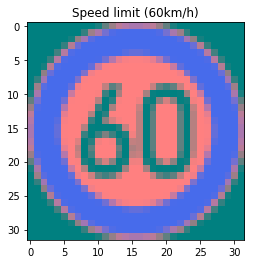

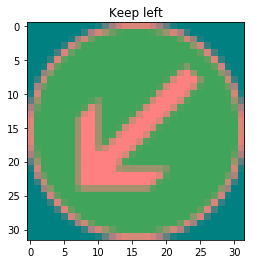

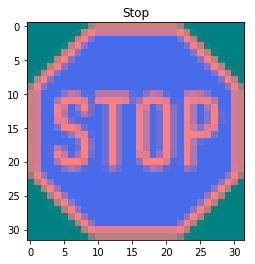

In [30]:
for index, logit in enumerate(predictions):
    sign_name = df_sign_names['SignName'][logit]
    plt.title(sign_name)
    plt.imshow(x_new[index], cmap = 'gray')
    plt.show()
    


### Analyze Performance

In [34]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    print("\n  Training set accuracy = {:.3f}".format(evaluate(x_new, y_new)))
   # print("Validation set accuracy = {:.3f}".format(evaluate(X_valid_standarized, y_valid)))
    #print("      Test set accuracy = {:.3f}".format(evaluate(X_test_standarized, y_test)))

INFO:tensorflow:Restoring parameters from ./lenet

  Training set accuracy = 1.000


In [32]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    softmax = sess.run(tf.nn.softmax(logits), feed_dict={x: x_new, keep_prob: 1.0})
    
    values, indices = sess.run(tf.nn.top_k(softmax, k=5))
    
np.set_printoptions(precision=5)
print('\n' + str(values))

INFO:tensorflow:Restoring parameters from ./lenet

[[  9.99998e-01   8.35876e-07   6.00434e-07   1.88250e-07   4.99211e-08]
 [  9.63001e-01   3.69991e-02   1.93807e-12   1.78132e-14   7.49293e-17]
 [  1.00000e+00   5.13522e-09   1.51031e-09   6.02147e-11   3.42353e-15]
 [  9.99938e-01   4.23082e-05   1.94350e-05   1.55136e-07   8.94959e-08]]


#### End